In [207]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator
from scipy.special import logsumexp
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

## Загрузка данных

In [208]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [209]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [210]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## Автокодировщик

In [211]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

In [212]:
autoencoder = Autoencoder()

In [213]:
device = torch.device("cpu")

In [214]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.L1Loss()
writer = SummaryWriter(log_dir="logs")

#### Обучение автокодировщика

In [215]:
train_losses = []
val_losses = []

In [216]:
epoch = 0
best_loss = np.inf
early_stop_counter = 0
patience = 3

In [217]:
while early_stop_counter <= patience:
    autoencoder.train()
    running_loss = 0.0

    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/train", avg_loss, epoch)

    autoencoder.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            test_running_loss += loss.item()

    test_avg_loss = test_running_loss / len(test_loader)
    writer.add_scalar("Loss/test", test_avg_loss, epoch)

    if (best_loss - avg_loss) > 0.01:
        best_loss = avg_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    epoch += 1
writer.close()

Epoch 7: 100%|██████████| 188/188 [00:16<00:00, 11.60it/s]


#### Графики

In [218]:
event_acc = event_accumulator.EventAccumulator("logs")
event_acc.Reload()

In [219]:
loss_train_events = event_acc.Scalars("Loss/train")
loss_test_events = event_acc.Scalars("Loss/test")

In [220]:
epochs_train = [e.step for e in loss_train_events]
avg_loss_train = [e.value for e in loss_train_events]

In [221]:
epochs_test = [e.step for e in loss_test_events]
avg_loss_test = [e.value for e in loss_test_events]

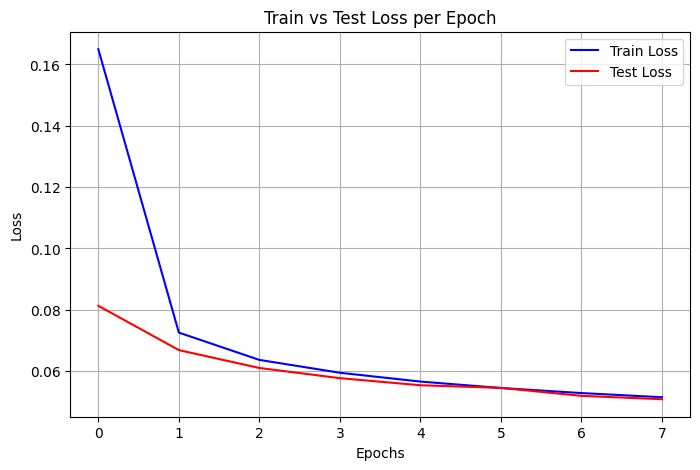

In [222]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_train, avg_loss_train, label="Train Loss", color="blue")
plt.plot(epochs_test, avg_loss_test, label="Test Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [223]:
autoencoder.eval()
x_sample, _ = next(iter(test_loader))
with torch.no_grad():
    reconstructed = autoencoder(x_sample)

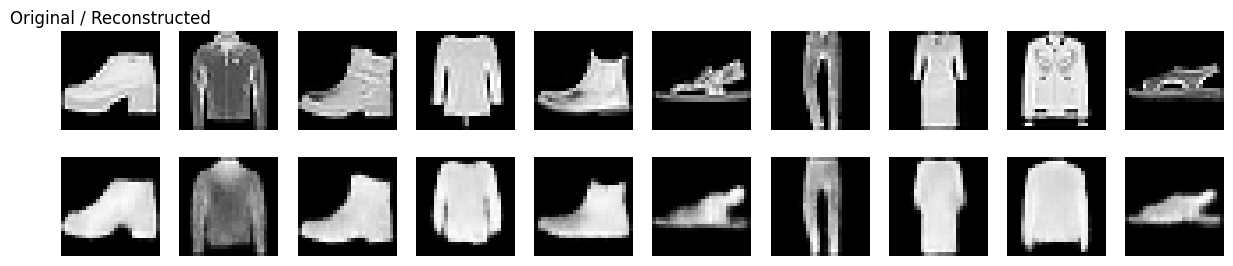

In [224]:
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0, i].imshow(x_sample[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_title('Original / Reconstructed')
plt.show()

## Гауссова модель и SMOTE

In [225]:
class GMM:
    def __init__(self, n_components=10, max_iter=100, tol=0.001, random_state=0):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = np.random.RandomState(random_state)

    def initialize_parameters(self, X):
        N, D = X.shape
        indices = self.random_state.choice(N, self.n_components, replace=False)
        self.means = X[indices]
        self.covariances = np.array([np.cov(X.T) + np.eye(D)*0.000001 for _ in range(self.n_components)])
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        N, D = X.shape
        log_prob = np.zeros((N, self.n_components))
        for k in range(self.n_components):
            diff = X - self.means[k]
            cov = self.covariances[k]
            inv_cov = np.linalg.inv(cov)
            log_det = np.linalg.slogdet(cov)[1]
            exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            log_prob[:, k] = np.log(self.weights[k]) - 0.5 * (log_det + D * np.log(2 * np.pi)) + exponent
        log_sum = logsumexp(log_prob, axis=1, keepdims=True)
        responsibilities = np.exp(log_prob - log_sum)
        return responsibilities

    def m_step(self, X, responsibilities):
        N, D = X.shape
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / N
        self.means = (responsibilities.T @ X) / Nk[:, np.newaxis]
        for k in range(self.n_components):
            diff = X - self.means[k]
            weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
            self.covariances[k] = (weighted_diff.T @ diff) / Nk[k] + np.eye(D) * 0.000001

    def fit(self, X):
        self.initialize_parameters(X)
        log_likelihood_old = None
        for iteration in range(self.max_iter):
            responsibilities = self.e_step(X)
            self.m_step(X, responsibilities)

            log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
            if log_likelihood_old is not None and abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood

    def sample(self, n_samples=1):
        component_ids = self.random_state.choice(self.n_components, size=n_samples, p=self.weights)
        samples = np.array([
            self.random_state.multivariate_normal(self.means[k], self.covariances[k])
            for k in component_ids
        ])
        return samples, component_ids

In [226]:
class SMOTE:
    def __init__(self, k_neighbors=5, random_state=0):
        self.k = k_neighbors
        self.random_state = np.random.RandomState(random_state)

    def fit_resample(self, X, y):
        X = np.array(X)
        y = np.array(y)
        counter = Counter(y)
        max_count = max(counter.values())

        X_resampled = [X]
        y_resampled = [y]

        for cls in counter:
            X_cls = X[y == cls]
            n_samples_to_add = max_count - len(X_cls)

            if n_samples_to_add <= 0:
                continue

            nn = NearestNeighbors(n_neighbors=self.k + 1)
            nn.fit(X_cls)
            neighbors = nn.kneighbors(X_cls, return_distance=False)[:, 1:]

            new_samples = []
            for _ in range(n_samples_to_add):
                i = self.random_state.randint(len(X_cls))
                xi = X_cls[i]
                neighbor_idx = self.random_state.choice(neighbors[i])
                xj = X_cls[neighbor_idx]
                lam = self.random_state.rand()
                new_sample = xi + lam * (xj - xi)
                new_samples.append(new_sample)

            X_resampled.append(np.array(new_samples))
            y_resampled.append(np.array([cls] * n_samples_to_add))

        X_final = np.vstack(X_resampled)
        y_final = np.concatenate(y_resampled)
        return X_final, y_final

In [227]:
features = []
images = []
labels = []

In [228]:
autoencoder.eval()
for x, y in train_loader:
    with torch.no_grad():
        z = autoencoder.encoder(x).numpy()
        features.append(z)
        images.append(x.view(x.size(0), -1).numpy())
        labels.append(y.numpy())

In [229]:
features = np.vstack(features)
images = np.vstack(images)
labels = np.hstack(labels)

GMM в скрытом пространстве

In [230]:
gmm_latent = GMM(n_components=10)
gmm_latent.fit(features)
z_gmm, _ = gmm_latent.sample(10)
x_gmm = autoencoder.decoder(torch.tensor(z_gmm).float())

GMM в пространстве изображений

In [231]:
gmm_img = GMM(n_components=10)
gmm_img.fit(images)
img_gmm, _ = gmm_img.sample(10)
x_gmm_img = torch.tensor(img_gmm).view(-1, 1, 28, 28)

SMOTE в скрытом пространстве

In [232]:
smote_latent = SMOTE()
features_smote, _ = smote_latent.fit_resample(features, labels)
x_smote = autoencoder.decoder(torch.tensor(features_smote[:10]).float())

SMOTE в пространстве изображений

In [233]:
smote_img = SMOTE()
img_smote, _ = smote_img.fit_resample(images, labels)
x_smote_img = torch.tensor(img_smote[:10]).view(-1, 1, 28, 28)

In [234]:
def show(images, title):
    images = images.detach().cpu().numpy()
    fig, axs = plt.subplots(1, len(images), figsize=(15, 2))
    for i in range(len(images)):
        axs[i].imshow(images[i].squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

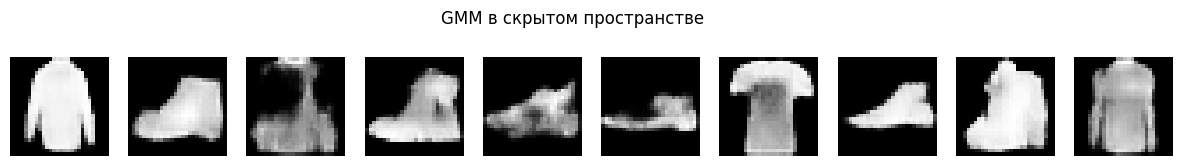

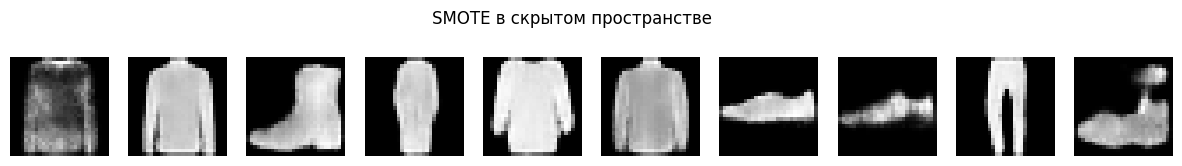

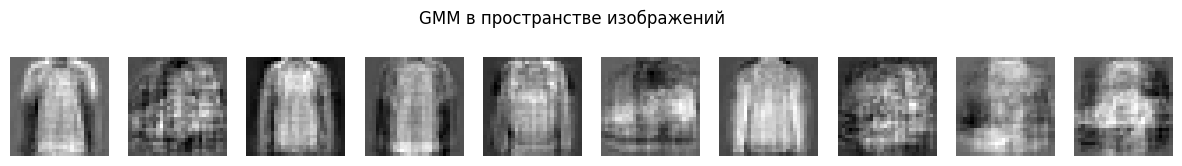

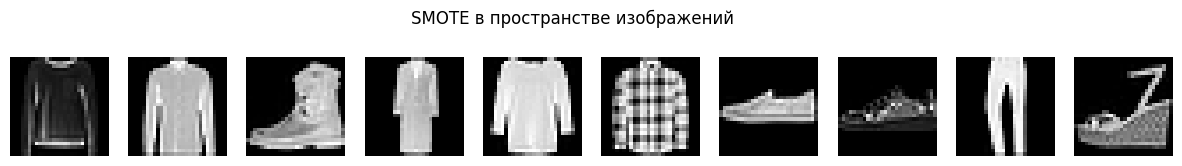

In [235]:
show(x_gmm, "GMM в скрытом пространстве")
show(x_smote, "SMOTE в скрытом пространстве")
show(x_gmm_img, "GMM в пространстве изображений")
show(x_smote_img, "SMOTE в пространстве изображений")

In [236]:
isu_number = 368939
model_id = isu_number % 3

In [237]:
model_id

2

## Диффузная модель

In [265]:
latent_dim = 64
num_classes = 10

Подготовка латентных векторов z и меток y

In [266]:
autoencoder.eval()
all_z = []
all_y = []
with torch.no_grad():
    for x, y in train_loader:
        z = autoencoder.encoder(x)
        all_z.append(z)
        all_y.append(y)     # [N]

In [267]:
z_train = torch.cat(all_z)
y_train = torch.cat(all_y)

In [268]:
autoencoder.eval()
all_z_test = []
all_y_test = []
with torch.no_grad():
    for x, y in test_loader:
        z = autoencoder.encoder(x)
        all_z_test.append(z)
        all_y_test.append(y)

In [269]:
z_test = torch.cat(all_z_test)
y_test = torch.cat(all_y_test)

Диффузионная модель

In [270]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq(x)

In [271]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, base_channels=32):
        super().__init__()

        self.label_emb = nn.Embedding(num_classes, 1)

        self.enc1 = DoubleConv(in_channels + 1, base_channels)
        self.enc2 = DoubleConv(base_channels, base_channels * 2)
        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(base_channels * 2, base_channels * 2)

        self.up = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_channels * 2, base_channels)
        self.out_conv = nn.Conv2d(base_channels, in_channels, kernel_size=1)

    def forward(self, x, t, y):
        B, C, H, W = x.shape

        y_emb = self.label_emb(y).view(B, 1, 1, 1).expand(-1, -1, H, W)
        x = torch.cat([x, y_emb], dim=1)

        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))

        x_mid = self.middle(x2)

        x_up = self.up(x_mid)
        x_cat = torch.cat([x_up, x1], dim=1)
        x_out = self.dec1(x_cat)
        return self.out_conv(x_out)

In [272]:
model = ConditionalUNet(in_channels=1, num_classes=10)

Обучение диффузионной модели

In [273]:
writer2 = SummaryWriter(log_dir='logs2')
batch_size = 128
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [274]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []

    perm = torch.randperm(len(z_train))

    for i in tqdm(range(0, len(z_train), batch_size), desc=f"Epoch {epoch}"):
        idx = perm[i:i + batch_size]
        z_batch = z_train[idx]
        y_batch = y_train[idx]

        noise = torch.randn_like(z_batch)
        t = torch.randint(0, 1000, (z_batch.size(0),), device=z_batch.device)
        z_noisy = z_batch + 0.1 * noise

        z_noisy = z_noisy.view(-1, 1, 8, 8)
        noise = noise.view(-1, 1, 8, 8)

        optimizer.zero_grad()
        pred = model(z_noisy, t, y_batch)
        loss = criterion(pred, noise)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    writer2.add_scalar("Loss/train", avg_loss, epoch)

    model.eval()
    test_running_loss = 0.0
    test_losses = []

    with torch.no_grad():
        for i in range(0, len(z_test), batch_size):
            idx = slice(i, i + batch_size)
            z_batch = z_test[idx]
            y_batch = y_test[idx]

            noise = torch.randn_like(z_batch)
            t = torch.randint(0, 1000, (z_batch.size(0),), device=z_batch.device)
            z_noisy = z_batch + 0.1 * noise

            z_noisy = z_noisy.view(-1, 1, 8, 8)
            noise = noise.view(-1, 1, 8, 8)

            pred = model(z_noisy, t, y_batch)
            loss = criterion(pred, noise)
            test_running_loss += loss.item()
            test_losses.append(loss.item())

    test_avg_loss = sum(test_losses) / len(test_losses)
    writer2.add_scalar("Loss/test", test_avg_loss, epoch)

    scheduler.step()
    loss_history.append(avg_loss)

writer2.close()


Epoch 19: 100%|██████████| 375/375 [00:21<00:00, 17.59it/s]


In [275]:
event_acc = event_accumulator.EventAccumulator("logs2")
event_acc.Reload()

In [276]:
loss_train_events = event_acc.Scalars("Loss/train")
loss_test_events = event_acc.Scalars("Loss/test")

In [277]:
epochs_train = [e.step for e in loss_train_events]
avg_loss_train = [e.value for e in loss_train_events]

In [278]:
epochs_test = [e.step for e in loss_test_events]
avg_loss_test = [e.value for e in loss_test_events]

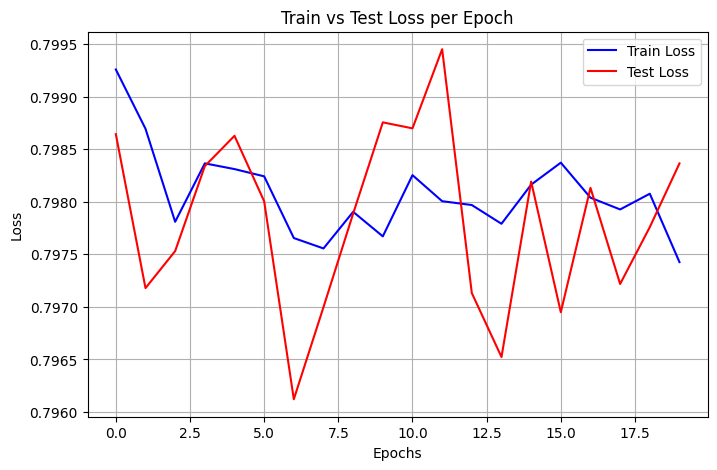

In [279]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_train, avg_loss_train, label="Train Loss", color="blue")
plt.plot(epochs_test, avg_loss_test, label="Test Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [280]:
autoencoder.eval().to(device)
model.eval().to(device)

ConditionalUNet(
  (label_emb): Embedding(10, 1)
  (enc1): DoubleConv(
    (seq): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (seq): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, paddi

Прямая генерация

In [281]:
z_direct = torch.randn(num_samples, latent_dim).to(device)
imgs_direct = autoencoder.decoder(z_direct).cpu()

Генерация через диффузию

In [282]:
z_diffused = torch.randn(num_samples, 1, 8, 8).to(device)
y_classes = torch.arange(0, num_samples).to(device)

In [283]:
with torch.no_grad():
    for t in reversed(range(1, 1001)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        noise_pred = model(z_diffused, t_tensor, y_classes)
        z_diffused = z_diffused - 0.1 * noise_pred

Переводим обратно в векторы

In [284]:
z_diffused_flat = z_diffused.view(num_samples, -1)
imgs_diffused = autoencoder.decoder(z_diffused_flat).cpu()

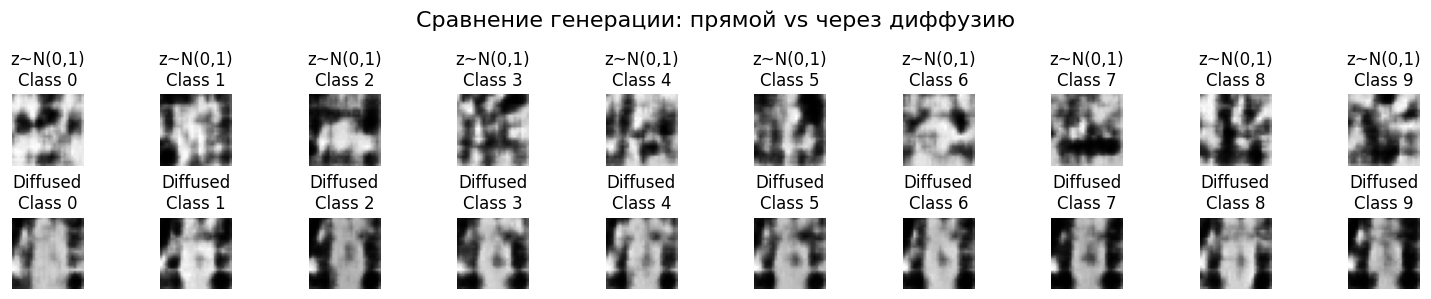

In [285]:
fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 1.5, 3))

for i in range(num_samples):
    axs[0, i].imshow(imgs_direct[i].detach().cpu().squeeze().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f"z~N(0,1)\nClass {i}")

    axs[1, i].imshow(imgs_diffused[i].detach().cpu().squeeze().numpy(), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Diffused\nClass {i}")

plt.suptitle("Сравнение генерации: прямой vs через диффузию", fontsize=16)
plt.tight_layout()
plt.show()

Семплирование из DDPM

In [286]:
def sample_ddpm(
    model,
    y,
    steps=1000,
    shape=(1, 8, 8),
    noise_scale=0.02,
    noise_back=True,
    use_z_mean=False,
    z_mean=None,
):
    model.eval()
    B = len(y)

    if use_z_mean and z_mean is not None:
        z_start = z_mean.expand(B, *z_mean.shape[1:])
        x = z_start + 0.2 * torch.randn(B, *shape)
    else:
        x = torch.randn(B, *shape)

    for t in reversed(range(1, steps + 1)):
        t_tensor = torch.full((B,), t, dtype=torch.long)
        with torch.no_grad():
            pred_noise = model(x, t_tensor, y)

        noise_term = 0.01 * torch.randn_like(x) if noise_back else 0.0
        x = x - noise_scale * pred_noise + noise_term

    return x

In [287]:
y_classes = torch.tensor([0, 1, 2, 3, 4])
z_gen = sample_ddpm(model, y_classes)
z_gen_flat = z_gen.view(-1, 64)
x_gen = autoencoder.decoder(z_gen_flat)

In [288]:
y_mixed = torch.tensor([0.5, 1.5, 2.5, 3.5, 4.5]).long()
z_mixed = sample_ddpm(model, y_mixed)
z_mixed = z_mixed.view(-1, 64)
x_mixed = autoencoder.decoder(z_mixed)

In [289]:
z_mean = torch.mean(z_train.view(-1, 1, 8, 8), dim=0, keepdim=True)
z_gen = sample_ddpm(model, y_classes, use_z_mean=True, z_mean=z_mean)

In [290]:
def show_images(images, title):
    images = images.detach().cpu().numpy()
    fig, axs = plt.subplots(1, len(images), figsize=(15, 2))
    for i, img in enumerate(images):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

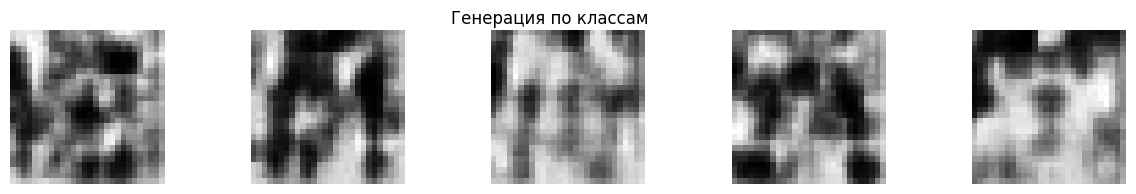

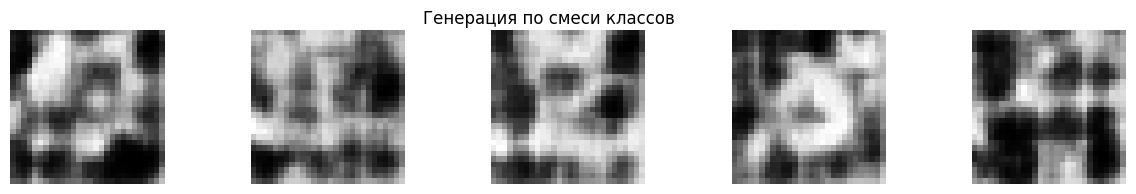

In [291]:
show_images(x_gen, "Генерация по классам")
show_images(x_mixed, "Генерация по смеси классов")